In [141]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns
import os
from itertools import product
import string

import matplotlib as mpl
from matplotlib import colors

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

In [2]:
mpl.rcParams['savefig.bbox'] = 'tight'
sns.set_style("white")
sns.set_style({'font.family':'sans-serif', 'font.serif':'Arial'})

In [3]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix], new_ix



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary

In [88]:
# MSM parameters

protein = 'CLN'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 100
nits= 25
lag = 31 
    #41
hp_ix = 218
    # hp_ixs = [52, 218]
n_ts = 10

# PCCA+ parameters
n_sets = 2
core_membership_cutoff = 0.95

# Input path 
summary_path = r'../CLN/maximize_t2.h5'
top_path = '../../../chignolin/protein.pdb'
    # '../../../1fme/protein.pdb'
traj_paths = list(Path(r'../../../chignolin').rglob(f'CLN025-0-protein-*.xtc'))
    # list(Path(r'../../../1fme').rglob(f'1FME-*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
ref_path = r'../../../chignolin/5AWL_H.pdb'
    # r'../../../1fme/1fme.pdb' 

In [5]:
hps = pd.read_hdf(summary_path)

# Rename hyperparameters
hps.rename(columns=dict(number='hp_ix', 
                        params_centre='distances__centre', 
                        params_feature='feature__value', 
                        params_n_clusters='cluster__k', 
                        params_scheme='distances__scheme', 
                        params_steepness='distances__steepness', 
                        params_tica_dim='tica__dim', 
                        params_tica_lag='tica__lag', 
                        params_transform='distances__transform'), inplace=True)
hps['tica__stride'] = 1
hps['cluster__stride'] = 1
hps['dihedrals__which'] = 'all'
hps['cluster__max_iter'] = 1000
hps['feature'] = hps.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)

# Rename features
def f(x):
    for short, long in short_names.items(): 
        x = x.replace(short, long)
    return x
short_names = {'dihedrals': 'dihed.','logistic-distances': 'logit(dist.)', 'linear-distances': 
              'dist.'}
hps['feature'] = hps['feature'].apply(f)
print(hps.columns)

Index(['hp_ix', 'value', 'datetime_start', 'datetime_complete', 'duration',
       'distances__centre', 'feature__value', 'cluster__k',
       'distances__scheme', 'distances__steepness', 'tica__dim', 'tica__lag',
       'distances__transform', 'state', 'tica__stride', 'cluster__stride',
       'dihedrals__which', 'cluster__max_iter', 'feature'],
      dtype='object')


---
### Compute BS MSM --- Figure 2

In [6]:
# Output path 
hps.set_index(['hp_ix'], inplace=True)
base_dir = Path(f"{protein}/hp{hp_ix}_{hps.loc[hp_ix,:]['feature']}")
fig_dir = Path.joinpath(base_dir, Path(f"figures"))
fig_dir.mkdir(parents=True, exist_ok=True)

In [7]:
ftrajs_all = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)

# Bootstrap results to get timescales and gaps
ts_samples = []
gap_samples = []

for i in range(n_bootstraps):
    #ftrajs = ftrajs_all
    ftrajs, ftrajs_ix = bootstrap(ftrajs_all, rng)
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path.joinpath(base_dir, Path(f'bs_{i}'))
    else:
        out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
    msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
    ts = msm.timescales(n_ts)
    
    ts_samples.append(ts[:-1]/1000)
    gap_samples.append(ts[:-1]/ts[1:])
    
ts_samples = np.array(ts_samples)
gap_samples = np.array(gap_samples)

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1812.48it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 462/469 [00:08<00
kmeans iterations:   0%| | 1/1000 [00:09<2:40:24,  9.6
kmeans iterations:   0%| | 2/1000 [00:10<1:12:14,  4.3
kmeans iterations:   0%| | 3/1000 [00:10<43:49,  2.64s

kmeans iterations:   1%| | 7/1000 [00:13<16:28,  1.00i
kmeans iterations:   1%| | 8/1000 [00:14<14:31,  1.14i
kmeans iterations:   1%| | 9/1000 [00:15<13:16,  1.24i
kmeans iterations:   1%| | 10/1000 [00:15<12:22,  1.33
kmeans iterations:   1%| | 11/1000 [00:16<11:55,  1.38
kmeans iterations:   1%| | 12/1000 [00:16<11:18,  1.46
kmeans iterations:   1%| | 13/1000 [00:17<11:02,  1.49
kmeans iterations:   1%| | 14/1000 [00:18<11:24,  1.44
kmeans iterations:   2%| | 15/1000 [00:19<15:00,  1.09
kmeans iterations:   2%| | 16/1000 [00:21<18:01,  1.10
kmeans iterations:   2%| | 17/1000 [00:22<18:30,  1.13
kmeans iterations:   2%| | 18/1000 [00:23<15:55,  1.03
kmeans iterations:   2%| | 19/1000 [00:23<14:14,  1.15
kmeans iterations:   2%| | 20/1000 [00:24<12:53,  1.27
kmeans iterations:   2%| | 21/1000 [00:25<12:10,  1.34
kmeans iterations:   2%| | 22/1000 [00:25<11:25,  1.43
initialize kmeans++ centers: 100%|█| 469/469 [00:26<00
kmeans iterations:   2%| | 24/1000 [00:26<10:49,  1.50
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:37<11:38,  1.38
kmeans iterations:   4%| | 38/1000 [00:37<11:17,  1.42
kmeans iterations:   4%| | 39/1000 [00:38<10:52,  1.47
100%|███████████████| 469/469 [00:39<00:00, 11.78it/s]

100%|████████████████| 54/54 [00:00<00:00, 442.50it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1955.62it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw

kmeans iterations:   1%| | 7/1000 [00:14<22:04,  1.33s
kmeans iterations:   1%| | 8/1000 [00:16<22:50,  1.38s
kmeans iterations:   1%| | 9/1000 [00:17<20:37,  1.25s
kmeans iterations:   1%| | 10/1000 [00:17<17:44,  1.08
kmeans iterations:   1%| | 11/1000 [00:18<15:42,  1.05
kmeans iterations:   1%| | 12/1000 [00:19<14:09,  1.16
kmeans iterations:   1%| | 13/1000 [00:19<13:03,  1.26
kmeans iterations:   1%| | 14/1000 [00:20<12:21,  1.33
kmeans iterations:   2%| | 15/1000 [00:20<11:48,  1.39
kmeans iterations:   2%| | 16/1000 [00:21<11:38,  1.41
kmeans iterations:   2%| | 17/1000 [00:22<11:18,  1.45
kmeans iterations:   2%| | 18/1000 [00:22<11:10,  1.46
kmeans iterations:   2%| | 19/1000 [00:23<10:55,  1.50
initialize kmeans++ centers: 100%|█| 469/469 [00:24<00
kmeans iterations:   2%| | 21/1000 [00:24<10:42,  1.52
kmeans iterations:   2%| | 22/1000 [00:25<10:40,  1.53
kmeans iterations:   2%| | 23/1000 [00:26<12:44,  1.28
kmeans iterations:   2%| | 24/1000 [00:28<16:13,  1.00
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:36<17:14,  1.07
kmeans iterations:   4%| | 38/1000 [00:37<17:24,  1.09
kmeans iterations:   4%| | 39/1000 [00:37<15:19,  1.05
kmeans iterations:   4%| | 40/1000 [00:38<13:48,  1.16
kmeans iterations:   4%| | 41/1000 [00:39<12:57,  1.23
kmeans iterations:   4%| | 42/1000 [00:39<11:59,  1.33
kmeans iterations:   4%| | 43/1000 [00:40<13:08,  1.21
kmeans iterations:   4%| | 44/1000 [00:42<16:45,  1.05
kmeans iterations:   4%| | 45/1000 [00:43<19:09,  1.20
kmeans iterations:   5%| | 46/1000 [00:44<16:37,  1.05
kmeans iterations:   5%| | 47/1000 [00:45<14:30,  1.10
kmeans iterations:   5%| | 48/1000 [00:45<13:08,  1.21
kmeans iterations:   5%| | 49/1000 [00:46<12:17,  1.29
kmeans iterations:   5%| | 50/1000 [00:47<12:18,  1.29
kmeans iterations:   5%| | 51/1000 [00:48<15:24,  1.03
kmeans iterations:   5%| | 52/1000 [00:50<18:25,  1.17
kmeans iterations:   5%| | 53/1000 [00:51<16:50,  1.07
kmeans iterations:   5%| | 54/1000 [00:51<14:50,  1.06
kmeans ite

kmeans iterations:   4%| | 38/1000 [00:48<19:33,  1.22
kmeans iterations:   4%| | 39/1000 [00:49<18:40,  1.17
kmeans iterations:   4%| | 40/1000 [00:49<16:20,  1.02
kmeans iterations:   4%| | 41/1000 [00:50<14:40,  1.09
kmeans iterations:   4%| | 42/1000 [00:51<13:22,  1.19
kmeans iterations:   4%| | 43/1000 [00:52<14:36,  1.09
kmeans iterations:   4%| | 44/1000 [00:54<17:58,  1.13
kmeans iterations:   4%| | 45/1000 [00:55<20:06,  1.26
kmeans iterations:   5%| | 46/1000 [00:56<17:10,  1.08
kmeans iterations:   5%| | 47/1000 [00:56<15:01,  1.06
kmeans iterations:   5%| | 48/1000 [00:57<13:45,  1.15
kmeans iterations:   5%| | 49/1000 [00:58<12:49,  1.24
kmeans iterations:   5%| | 50/1000 [00:59<12:48,  1.24
kmeans iterations:   5%| | 51/1000 [00:59<12:07,  1.30
kmeans iterations:   5%| | 52/1000 [01:00<11:32,  1.37
100%|███████████████| 469/469 [01:03<00:00,  7.38it/s]

100%|████████████████| 54/54 [00:00<00:00, 212.29it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/

kmeans iterations:   5%| | 48/1000 [00:44<10:15,  1.55
kmeans iterations:   5%| | 49/1000 [00:45<10:10,  1.56
kmeans iterations:   5%| | 50/1000 [00:45<10:10,  1.56
kmeans iterations:   5%| | 51/1000 [00:46<10:25,  1.52
kmeans iterations:   5%| | 52/1000 [00:47<11:12,  1.41
100%|███████████████| 469/469 [00:49<00:00,  9.51it/s]

100%|████████████████| 54/54 [00:00<00:00, 210.96it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████| 54/54 [00:00<00:00, 845.66it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packag

100%|███████████████| 54/54 [00:00<00:00, 1023.87it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|▉| 467/469 [00:08<00
kmeans iterations:   0%| | 1/1000 [00:09<2:40:03,  9.6
kmeans iterations:   0%| | 2/1000 [00:10<1:12:04,  4.3
kmeans iterations:   0%| | 3/1000 [00:10<43:56,  2.64s
kmeans iterations:   0%| | 4/1000 [00:11<30:51,  1.86s
kmeans iterations:   0%| | 5/1000 [00:12<23:24,  1.41s
kmeans iterations:   1%| | 6/1000 [00:12<19:12,  1.16s
kmeans iterations:   1%| | 7/1000 [00:13<16:28,  1.00i
kmeans iterations:   1%| | 8/1000 [00:14<14:39,  1.13i
kmeans iterations:   1%| | 9/1000 [00:14<13:21,  1.24i


kmeans iterations:   1%| | 7/1000 [00:13<15:59,  1.03i
kmeans iterations:   1%| | 8/1000 [00:13<14:14,  1.16i
kmeans iterations:   1%| | 9/1000 [00:14<13:37,  1.21i
kmeans iterations:   1%| | 10/1000 [00:15<13:18,  1.24
kmeans iterations:   1%| | 11/1000 [00:16<17:03,  1.03
kmeans iterations:   1%| | 12/1000 [00:18<19:40,  1.20
kmeans iterations:   1%| | 13/1000 [00:19<19:14,  1.17
kmeans iterations:   1%| | 14/1000 [00:20<16:48,  1.02
kmeans iterations:   2%| | 15/1000 [00:20<14:49,  1.11
kmeans iterations:   2%| | 16/1000 [00:21<13:37,  1.20
kmeans iterations:   2%| | 17/1000 [00:22<12:43,  1.29
kmeans iterations:   2%| | 18/1000 [00:22<12:04,  1.36
kmeans iterations:   2%| | 19/1000 [00:23<11:40,  1.40
kmeans iterations:   2%| | 20/1000 [00:24<11:19,  1.44
initialize kmeans++ centers: 100%|█| 469/469 [00:25<00
kmeans iterations:   2%| | 22/1000 [00:25<10:49,  1.51
kmeans iterations:   2%| | 23/1000 [00:26<10:46,  1.51
kmeans iterations:   2%| | 24/1000 [00:26<10:42,  1.52
kmeans ite

kmeans iterations:   1%| | 13/1000 [00:20<12:15,  1.34
kmeans iterations:   1%| | 14/1000 [00:21<11:38,  1.41
kmeans iterations:   2%| | 15/1000 [00:22<13:55,  1.18
kmeans iterations:   2%| | 16/1000 [00:24<17:28,  1.07
kmeans iterations:   2%| | 17/1000 [00:25<18:17,  1.12
kmeans iterations:   2%| | 18/1000 [00:26<15:53,  1.03
kmeans iterations:   2%| | 19/1000 [00:26<14:15,  1.15
kmeans iterations:   2%| | 20/1000 [00:27<13:06,  1.25
initialize kmeans++ centers: 100%|█| 469/469 [00:28<00
kmeans iterations:   2%| | 22/1000 [00:28<11:35,  1.41
kmeans iterations:   2%| | 23/1000 [00:29<12:27,  1.31
kmeans iterations:   2%| | 24/1000 [00:31<16:19,  1.00
kmeans iterations:   2%| | 25/1000 [00:32<19:04,  1.17
kmeans iterations:   3%| | 26/1000 [00:33<17:13,  1.06
kmeans iterations:   3%| | 27/1000 [00:34<15:23,  1.05
kmeans iterations:   3%| | 28/1000 [00:34<13:48,  1.17
kmeans iterations:   3%| | 29/1000 [00:35<12:46,  1.27
kmeans iterations:   3%| | 30/1000 [00:36<12:27,  1.30
kmeans ite

kmeans iterations:   3%| | 34/1000 [00:44<17:57,  1.12
kmeans iterations:   4%| | 35/1000 [00:45<20:26,  1.27
kmeans iterations:   4%| | 36/1000 [00:46<17:35,  1.09
kmeans iterations:   4%| | 37/1000 [00:47<15:17,  1.05
kmeans iterations:   4%| | 38/1000 [00:47<13:49,  1.16
kmeans iterations:   4%| | 39/1000 [00:48<14:11,  1.13
kmeans iterations:   4%| | 40/1000 [00:50<16:49,  1.05
kmeans iterations:   4%| | 41/1000 [00:51<18:31,  1.16
kmeans iterations:   4%| | 42/1000 [00:52<16:03,  1.01
kmeans iterations:   4%| | 43/1000 [00:53<14:21,  1.11
kmeans iterations:   4%| | 44/1000 [00:53<13:09,  1.21
kmeans iterations:   4%| | 45/1000 [00:54<12:45,  1.25
kmeans iterations:   5%| | 46/1000 [00:55<16:06,  1.01
kmeans iterations:   5%| | 47/1000 [00:57<19:04,  1.20
kmeans iterations:   5%| | 48/1000 [00:58<18:04,  1.14
kmeans iterations:   5%| | 49/1000 [00:59<15:43,  1.01
kmeans iterations:   5%| | 50/1000 [00:59<14:04,  1.13
kmeans iterations:   5%| | 51/1000 [01:00<14:57,  1.06
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:43<12:00,  1.34
kmeans iterations:   4%| | 38/1000 [00:44<11:22,  1.41
kmeans iterations:   4%| | 39/1000 [00:45<10:56,  1.46
kmeans iterations:   4%| | 40/1000 [00:46<13:32,  1.18
kmeans iterations:   4%| | 41/1000 [00:47<17:09,  1.07
kmeans iterations:   4%| | 42/1000 [00:49<18:46,  1.18
kmeans iterations:   4%| | 43/1000 [00:49<16:00,  1.00
100%|███████████████| 469/469 [00:51<00:00,  9.17it/s]

100%|████████████████| 54/54 [00:00<00:00, 401.80it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1723.53it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to d

kmeans iterations:   4%| | 42/1000 [00:44<16:12,  1.02
kmeans iterations:   4%| | 43/1000 [00:45<14:13,  1.12
kmeans iterations:   4%| | 44/1000 [00:46<12:49,  1.24
100%|███████████████| 469/469 [00:47<00:00,  9.91it/s]

100%|████████████████| 54/54 [00:00<00:00, 438.68it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1969.81it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw

initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|█| 469/469 [00:08<00
kmeans iterations:   0%| | 1/1000 [00:09<2:43:41,  9.8
kmeans iterations:   0%| | 2/1000 [00:11<1:22:25,  4.9
kmeans iterations:   0%| | 3/1000 [00:12<54:49,  3.30s
kmeans iterations:   0%| | 4/1000 [00:13<37:10,  2.24s
kmeans iterations:   0%| | 5/1000 [00:13<27:17,  1.65s
kmeans iterations:   1%| | 6/1000 [00:14<21:22,  1.29s
kmeans iterations:   1%| | 7/1000 [00:15<17:41,  1.07s
kmeans iterations:   1%| | 8/1000 [00:15<15:19,  1.08i
kmeans iterations:   1%| | 9/1000 [00:16<13:34,  1.22i
kmeans iterations:   1%| | 10/1000 [00:16<12:23,  1.33
kmeans iterations:   1%| | 11/1000 [00:17<11:36,  1.42
kmeans iterations:   1%| | 12/1000 [00:18<11:36,  1.42
kmeans iterations:   1%| | 13/1000 [00:19<15:29,  1.06
kmeans iterations:   1%| | 14/1000 [00:21<18:51,  1.15
kmeans iterations:   2%| | 15/1000 [00:22<19:16,  1.17
initialize kmeans++ centers: 100%|█| 469/469 [00:23<00
kmeans ite

kmeans iterations:   3%| | 28/1000 [00:41<19:56,  1.23
kmeans iterations:   3%| | 29/1000 [00:42<18:39,  1.15
kmeans iterations:   3%| | 30/1000 [00:43<16:05,  1.00
kmeans iterations:   3%| | 31/1000 [00:44<15:26,  1.05
kmeans iterations:   3%| | 32/1000 [00:45<18:49,  1.17
kmeans iterations:   3%| | 33/1000 [00:47<21:11,  1.32
kmeans iterations:   3%| | 34/1000 [00:48<17:56,  1.11
kmeans iterations:   4%| | 35/1000 [00:48<15:39,  1.03
kmeans iterations:   4%| | 36/1000 [00:49<15:18,  1.05
kmeans iterations:   4%| | 37/1000 [00:51<17:36,  1.10
kmeans iterations:   4%| | 38/1000 [00:52<19:24,  1.21
kmeans iterations:   4%| | 39/1000 [00:53<16:45,  1.05
kmeans iterations:   4%| | 40/1000 [00:54<14:53,  1.07
kmeans iterations:   4%| | 41/1000 [00:55<15:53,  1.01
kmeans iterations:   4%| | 42/1000 [00:56<18:18,  1.15
kmeans iterations:   4%| | 43/1000 [00:57<18:19,  1.15
100%|███████████████| 469/469 [00:59<00:00,  7.94it/s]

100%|████████████████| 54/54 [00:00<00:00, 183.76it/s]
/home/rzh

100%|████████████████| 54/54 [00:00<00:00, 883.38it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|▉| 468/469 [00:07<00
kmeans iterations:   0%| | 1/1000 [00:08<2:27:14,  8.8
kmeans iterations:   0%| | 2/1000 [00:10<1:14:26,  4.4
kmeans iterations:   0%| | 3/1000 [00:10<45:13,  2.72s
kmeans iterations:   0%| | 4/1000 [00:11<31:13,  1.88s
kmeans iterations:   0%| | 5/1000 [00:12<23:30,  1.42s
kmeans iterations:   1%| | 6/1000 [00:12<18:50,  1.14s
kmeans iterations:   1%| | 7/1000 [00:13<15:52,  1.04i
kmeans iterations:   1%| | 8/1000 [00:13<13:59,  1.18i
kmeans iterations:   1%| | 9/1000 [00:14<12:41,  1.30i


kmeans iterations:   1%| | 14/1000 [00:18<12:59,  1.27
kmeans iterations:   2%| | 15/1000 [00:19<16:52,  1.03
initialize kmeans++ centers: 100%|█| 469/469 [00:22<00
kmeans iterations:   2%| | 17/1000 [00:22<17:46,  1.09
kmeans iterations:   2%| | 18/1000 [00:22<15:36,  1.05
kmeans iterations:   2%| | 19/1000 [00:23<13:58,  1.17
kmeans iterations:   2%| | 20/1000 [00:24<12:44,  1.28
kmeans iterations:   2%| | 21/1000 [00:24<12:00,  1.36
kmeans iterations:   2%| | 22/1000 [00:25<11:28,  1.42
kmeans iterations:   2%| | 23/1000 [00:25<11:23,  1.43
kmeans iterations:   2%| | 24/1000 [00:26<11:06,  1.46
kmeans iterations:   2%| | 25/1000 [00:27<10:56,  1.49
kmeans iterations:   3%| | 26/1000 [00:27<10:54,  1.49
kmeans iterations:   3%| | 27/1000 [00:28<10:34,  1.53
kmeans iterations:   3%| | 28/1000 [00:29<10:19,  1.57
kmeans iterations:   3%| | 29/1000 [00:29<10:55,  1.48
kmeans iterations:   3%| | 30/1000 [00:30<10:50,  1.49
kmeans iterations:   3%| | 31/1000 [00:32<14:52,  1.09
kmeans ite

kmeans iterations:   4%| | 35/1000 [00:31<10:19,  1.56
kmeans iterations:   4%| | 36/1000 [00:31<10:24,  1.54
kmeans iterations:   4%| | 37/1000 [00:32<10:21,  1.55
kmeans iterations:   4%| | 38/1000 [00:33<10:20,  1.55
kmeans iterations:   4%| | 39/1000 [00:33<10:21,  1.55
kmeans iterations:   4%| | 40/1000 [00:34<10:19,  1.55
kmeans iterations:   4%| | 41/1000 [00:35<10:19,  1.55
kmeans iterations:   4%| | 42/1000 [00:35<10:22,  1.54
kmeans iterations:   4%| | 43/1000 [00:36<10:17,  1.55
kmeans iterations:   4%| | 44/1000 [00:37<10:10,  1.57
kmeans iterations:   4%| | 45/1000 [00:37<10:06,  1.58
kmeans iterations:   5%| | 46/1000 [00:38<10:06,  1.57
kmeans iterations:   5%| | 47/1000 [00:39<10:12,  1.56
kmeans iterations:   5%| | 48/1000 [00:39<10:05,  1.57
kmeans iterations:   5%| | 49/1000 [00:40<10:05,  1.57
kmeans iterations:   5%| | 50/1000 [00:40<10:11,  1.55
kmeans iterations:   5%| | 51/1000 [00:41<10:12,  1.55
kmeans iterations:   5%| | 52/1000 [00:42<10:09,  1.56
kmeans ite

kmeans iterations:   2%| | 20/1000 [00:19<10:31,  1.55
kmeans iterations:   2%| | 21/1000 [00:19<10:29,  1.56
kmeans iterations:   2%| | 22/1000 [00:20<10:20,  1.58
kmeans iterations:   2%| | 23/1000 [00:21<10:20,  1.57
kmeans iterations:   2%| | 24/1000 [00:21<10:14,  1.59
kmeans iterations:   2%| | 25/1000 [00:22<10:15,  1.58
kmeans iterations:   3%| | 26/1000 [00:23<11:38,  1.39
kmeans iterations:   3%| | 27/1000 [00:24<15:43,  1.03
kmeans iterations:   3%| | 28/1000 [00:26<18:05,  1.12
kmeans iterations:   3%| | 29/1000 [00:27<17:45,  1.10
kmeans iterations:   3%| | 30/1000 [00:27<15:36,  1.04
kmeans iterations:   3%| | 31/1000 [00:28<14:09,  1.14
kmeans iterations:   3%| | 32/1000 [00:29<13:05,  1.23
kmeans iterations:   3%| | 33/1000 [00:29<12:24,  1.30
kmeans iterations:   3%| | 34/1000 [00:30<11:52,  1.36
kmeans iterations:   4%| | 35/1000 [00:31<11:32,  1.39
kmeans iterations:   4%| | 36/1000 [00:31<11:16,  1.43
kmeans iterations:   4%| | 37/1000 [00:32<11:19,  1.42
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:38<10:51,  1.48
kmeans iterations:   4%| | 38/1000 [00:38<10:42,  1.50
kmeans iterations:   4%| | 39/1000 [00:39<10:35,  1.51
kmeans iterations:   4%| | 40/1000 [00:39<10:32,  1.52
kmeans iterations:   4%| | 41/1000 [00:40<10:35,  1.51
kmeans iterations:   4%| | 42/1000 [00:41<10:31,  1.52
kmeans iterations:   4%| | 43/1000 [00:42<11:11,  1.43
kmeans iterations:   4%| | 44/1000 [00:43<14:32,  1.10
kmeans iterations:   4%| | 45/1000 [00:45<17:47,  1.12
kmeans iterations:   5%| | 46/1000 [00:46<18:09,  1.14
kmeans iterations:   5%| | 47/1000 [00:47<15:59,  1.01
kmeans iterations:   5%| | 48/1000 [00:47<14:28,  1.10
kmeans iterations:   5%| | 49/1000 [00:48<13:07,  1.21
kmeans iterations:   5%| | 50/1000 [00:48<12:18,  1.29
kmeans iterations:   5%| | 51/1000 [00:49<11:54,  1.33
kmeans iterations:   5%| | 52/1000 [00:50<11:26,  1.38
kmeans iterations:   5%| | 53/1000 [00:51<11:17,  1.40
kmeans iterations:   5%| | 54/1000 [00:51<11:11,  1.41
kmeans ite

kmeans iterations:   3%| | 34/1000 [00:35<18:34,  1.15
kmeans iterations:   4%| | 35/1000 [00:36<15:59,  1.01
kmeans iterations:   4%| | 36/1000 [00:36<14:17,  1.12
kmeans iterations:   4%| | 37/1000 [00:37<12:58,  1.24
kmeans iterations:   4%| | 38/1000 [00:37<12:10,  1.32
kmeans iterations:   4%| | 39/1000 [00:38<11:28,  1.40
kmeans iterations:   4%| | 40/1000 [00:39<11:07,  1.44
kmeans iterations:   4%| | 41/1000 [00:39<10:43,  1.49
kmeans iterations:   4%| | 42/1000 [00:40<10:35,  1.51
100%|███████████████| 469/469 [00:41<00:00, 11.24it/s]

100%|████████████████| 54/54 [00:00<00:00, 435.64it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████| 54/54 [00:00<00:00, 952.65it/s]
/home/rz

100%|████████████████| 54/54 [00:00<00:00, 438.37it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████| 54/54 [00:00<00:00, 982.61it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 465/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:07<2:02:33,  7.3
kmeans iterations:   0%| | 2/1000 [00:07<56:26,  3.39s

kmeans iterations:   2%| | 22/1000 [00:30<13:29,  1.21
kmeans iterations:   2%| | 23/1000 [00:31<15:29,  1.05
kmeans iterations:   2%| | 24/1000 [00:33<18:37,  1.15
kmeans iterations:   2%| | 25/1000 [00:34<19:57,  1.23
kmeans iterations:   3%| | 26/1000 [00:35<17:01,  1.05
kmeans iterations:   3%| | 27/1000 [00:35<15:00,  1.08
kmeans iterations:   3%| | 28/1000 [00:36<13:30,  1.20
kmeans iterations:   3%| | 29/1000 [00:37<12:33,  1.29
kmeans iterations:   3%| | 30/1000 [00:38<13:47,  1.17
kmeans iterations:   3%| | 31/1000 [00:39<17:19,  1.07
kmeans iterations:   3%| | 32/1000 [00:41<19:46,  1.23
kmeans iterations:   3%| | 33/1000 [00:42<17:34,  1.09
kmeans iterations:   3%| | 34/1000 [00:42<15:17,  1.05
kmeans iterations:   4%| | 35/1000 [00:43<13:47,  1.17
kmeans iterations:   4%| | 36/1000 [00:44<12:42,  1.26
kmeans iterations:   4%| | 37/1000 [00:44<12:00,  1.34
kmeans iterations:   4%| | 38/1000 [00:45<11:25,  1.40
kmeans iterations:   4%| | 39/1000 [00:46<14:11,  1.13
kmeans ite

kmeans iterations:   2%| | 24/1000 [00:30<16:31,  1.02
kmeans iterations:   2%| | 25/1000 [00:31<14:49,  1.10
kmeans iterations:   3%| | 26/1000 [00:31<13:26,  1.21
kmeans iterations:   3%| | 27/1000 [00:32<12:37,  1.29
kmeans iterations:   3%| | 28/1000 [00:33<12:42,  1.27
kmeans iterations:   3%| | 29/1000 [00:34<12:00,  1.35
kmeans iterations:   3%| | 30/1000 [00:34<11:29,  1.41
kmeans iterations:   3%| | 31/1000 [00:35<11:41,  1.38
kmeans iterations:   3%| | 32/1000 [00:37<15:48,  1.02
kmeans iterations:   3%| | 33/1000 [00:38<18:53,  1.17
kmeans iterations:   3%| | 34/1000 [00:39<16:52,  1.05
kmeans iterations:   4%| | 35/1000 [00:40<14:59,  1.07
100%|███████████████| 469/469 [00:41<00:00, 11.33it/s]

100%|████████████████| 54/54 [00:00<00:00, 430.42it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorato

100%|███████████████| 469/469 [01:05<00:00,  7.16it/s]

100%|████████████████| 54/54 [00:00<00:00, 232.69it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 2669.61it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|▉| 467/469 [00:09<00
kmeans iterations:   0%| | 1/1000 [00:09<2:43:45,  9.

kmeans iterations:   1%| | 7/1000 [00:15<21:38,  1.31s
kmeans iterations:   1%| | 8/1000 [00:15<17:58,  1.09s
kmeans iterations:   1%| | 9/1000 [00:16<15:34,  1.06i
kmeans iterations:   1%| | 10/1000 [00:17<14:07,  1.17
kmeans iterations:   1%| | 11/1000 [00:17<13:08,  1.25
kmeans iterations:   1%| | 12/1000 [00:18<12:26,  1.32
initialize kmeans++ centers: 100%|█| 469/469 [00:19<00
kmeans iterations:   1%| | 14/1000 [00:19<11:23,  1.44
kmeans iterations:   2%| | 15/1000 [00:20<10:55,  1.50
kmeans iterations:   2%| | 16/1000 [00:20<10:42,  1.53
kmeans iterations:   2%| | 17/1000 [00:21<10:28,  1.56
kmeans iterations:   2%| | 18/1000 [00:22<10:15,  1.59
kmeans iterations:   2%| | 19/1000 [00:22<10:51,  1.51
kmeans iterations:   2%| | 20/1000 [00:24<13:56,  1.17
kmeans iterations:   2%| | 21/1000 [00:25<17:20,  1.06
kmeans iterations:   2%| | 22/1000 [00:26<17:55,  1.10
kmeans iterations:   2%| | 23/1000 [00:27<15:34,  1.05
kmeans iterations:   2%| | 24/1000 [00:28<13:52,  1.17
kmeans ite

kmeans iterations:   3%| | 34/1000 [00:34<12:32,  1.28
kmeans iterations:   4%| | 35/1000 [00:35<11:56,  1.35
kmeans iterations:   4%| | 36/1000 [00:36<11:19,  1.42
kmeans iterations:   4%| | 37/1000 [00:36<10:53,  1.47
kmeans iterations:   4%| | 38/1000 [00:37<10:35,  1.51
kmeans iterations:   4%| | 39/1000 [00:38<10:23,  1.54
kmeans iterations:   4%| | 40/1000 [00:39<12:59,  1.23
kmeans iterations:   4%| | 41/1000 [00:40<16:27,  1.03
kmeans iterations:   4%| | 42/1000 [00:42<18:31,  1.16
kmeans iterations:   4%| | 43/1000 [00:42<16:06,  1.01
100%|███████████████| 469/469 [00:44<00:00, 10.59it/s]

100%|████████████████| 54/54 [00:00<00:00, 461.60it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███

100%|████████████████| 54/54 [00:00<00:00, 457.73it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1351.48it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|▉| 468/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:07<2:00:39,  7.2
kmeans iterations:   0%| | 2/1000 [00:07<55:48,  3.36s

initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|▉| 467/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:07<2:00:21,  7.2
kmeans iterations:   0%| | 2/1000 [00:07<55:42,  3.35s
kmeans iterations:   0%| | 3/1000 [00:08<35:06,  2.11s
kmeans iterations:   0%| | 4/1000 [00:09<25:25,  1.53s
kmeans iterations:   0%| | 5/1000 [00:09<20:20,  1.23s
kmeans iterations:   1%| | 6/1000 [00:10<16:58,  1.02s
kmeans iterations:   1%| | 7/1000 [00:11<14:54,  1.11i
kmeans iterations:   1%| | 8/1000 [00:11<13:43,  1.20i
kmeans iterations:   1%| | 9/1000 [00:12<12:44,  1.30i
kmeans iterations:   1%| | 10/1000 [00:13<11:59,  1.38
kmeans iterations:   1%| | 11/1000 [00:13<11:29,  1.43
kmeans iterations:   1%| | 12/1000 [00:14<11:12,  1.47
kmeans iterations:   1%| | 13/1000 [00:15<11:08,  1.48
kmeans iterations:   1%| | 14/1000 [00:15<10:55,  1.51
kmeans iterations:   2%| | 15/1000 [00:16<10:58,  1.50
kmeans iterations:   2%| | 16/1000 [00:16<10:57,  1.50
kmeans ite

kmeans iterations:   2%| | 23/1000 [00:28<13:53,  1.17
kmeans iterations:   2%| | 24/1000 [00:28<12:37,  1.29
kmeans iterations:   2%| | 25/1000 [00:29<12:02,  1.35
kmeans iterations:   3%| | 26/1000 [00:29<11:19,  1.43
kmeans iterations:   3%| | 27/1000 [00:30<10:58,  1.48
kmeans iterations:   3%| | 28/1000 [00:31<10:33,  1.54
kmeans iterations:   3%| | 29/1000 [00:31<10:23,  1.56
kmeans iterations:   3%| | 30/1000 [00:32<10:06,  1.60
kmeans iterations:   3%| | 31/1000 [00:33<10:53,  1.48
kmeans iterations:   3%| | 32/1000 [00:34<14:24,  1.12
kmeans iterations:   3%| | 33/1000 [00:36<17:38,  1.09
kmeans iterations:   3%| | 34/1000 [00:37<18:13,  1.13
kmeans iterations:   4%| | 35/1000 [00:37<15:47,  1.02
kmeans iterations:   4%| | 36/1000 [00:38<13:52,  1.16
kmeans iterations:   4%| | 37/1000 [00:39<12:41,  1.26
kmeans iterations:   4%| | 38/1000 [00:39<11:44,  1.37
100%|███████████████| 469/469 [00:40<00:00, 11.46it/s]

100%|████████████████| 54/54 [00:00<00:00, 445.04it/s]
/home/rzh

kmeans iterations:   3%| | 27/1000 [00:28<10:42,  1.51
kmeans iterations:   3%| | 28/1000 [00:29<11:31,  1.41
kmeans iterations:   3%| | 29/1000 [00:31<15:22,  1.05
kmeans iterations:   3%| | 30/1000 [00:32<18:34,  1.15
kmeans iterations:   3%| | 31/1000 [00:33<18:10,  1.13
kmeans iterations:   3%| | 32/1000 [00:34<15:58,  1.01
kmeans iterations:   3%| | 33/1000 [00:35<14:11,  1.14
kmeans iterations:   3%| | 34/1000 [00:35<12:50,  1.25
kmeans iterations:   4%| | 35/1000 [00:36<11:57,  1.35
kmeans iterations:   4%| | 36/1000 [00:37<11:31,  1.39
kmeans iterations:   4%| | 37/1000 [00:37<11:21,  1.41
kmeans iterations:   4%| | 38/1000 [00:38<10:59,  1.46
kmeans iterations:   4%| | 39/1000 [00:39<10:52,  1.47
kmeans iterations:   4%| | 40/1000 [00:39<10:30,  1.52
kmeans iterations:   4%| | 41/1000 [00:40<10:22,  1.54
kmeans iterations:   4%| | 42/1000 [00:41<11:44,  1.36
kmeans iterations:   4%| | 43/1000 [00:42<15:42,  1.02
kmeans iterations:   4%| | 44/1000 [00:44<18:24,  1.16
kmeans ite

100%|████████████████| 54/54 [00:00<00:00, 176.72it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1867.53it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|█| 469/469 [00:11<00
kmeans iterations:   0%| | 1/1000 [00:12<3:26:28, 12.4
kmeans iterations:   0%| | 2/1000 [00:13<1:30:52,  5.4

kmeans iterations:   1%| | 7/1000 [00:18<22:42,  1.37s
kmeans iterations:   1%| | 8/1000 [00:19<23:48,  1.44s
kmeans iterations:   1%| | 9/1000 [00:21<24:20,  1.47s
kmeans iterations:   1%| | 10/1000 [00:22<20:16,  1.23
kmeans iterations:   1%| | 11/1000 [00:22<17:18,  1.05
kmeans iterations:   1%| | 12/1000 [00:23<15:19,  1.07
kmeans iterations:   1%| | 13/1000 [00:24<14:55,  1.10
kmeans iterations:   1%| | 14/1000 [00:25<18:19,  1.11
kmeans iterations:   2%| | 15/1000 [00:27<21:00,  1.28
kmeans iterations:   2%| | 16/1000 [00:28<18:01,  1.10
kmeans iterations:   2%| | 17/1000 [00:28<15:55,  1.03
initialize kmeans++ centers: 100%|█| 469/469 [00:30<00
kmeans iterations:   2%| | 19/1000 [00:30<16:32,  1.01
kmeans iterations:   2%| | 20/1000 [00:32<19:29,  1.19
kmeans iterations:   2%| | 21/1000 [00:33<19:07,  1.17
kmeans iterations:   2%| | 22/1000 [00:34<16:33,  1.02
kmeans iterations:   2%| | 23/1000 [00:34<14:43,  1.11
kmeans iterations:   2%| | 24/1000 [00:35<14:04,  1.16
kmeans ite

kmeans iterations:   4%| | 36/1000 [00:40<13:47,  1.16
kmeans iterations:   4%| | 37/1000 [00:42<16:31,  1.03
kmeans iterations:   4%| | 38/1000 [00:43<18:40,  1.16
kmeans iterations:   4%| | 39/1000 [00:44<16:09,  1.01
kmeans iterations:   4%| | 40/1000 [00:44<14:24,  1.11
kmeans iterations:   4%| | 41/1000 [00:45<13:10,  1.21
kmeans iterations:   4%| | 42/1000 [00:46<12:24,  1.29
kmeans iterations:   4%| | 43/1000 [00:46<11:45,  1.36
kmeans iterations:   4%| | 44/1000 [00:47<13:06,  1.22
kmeans iterations:   4%| | 45/1000 [00:49<16:31,  1.04
kmeans iterations:   5%| | 46/1000 [00:51<18:52,  1.19
kmeans iterations:   5%| | 47/1000 [00:51<16:15,  1.02
kmeans iterations:   5%| | 48/1000 [00:52<14:23,  1.10
kmeans iterations:   5%| | 49/1000 [00:52<13:09,  1.20
kmeans iterations:   5%| | 50/1000 [00:53<12:14,  1.29
kmeans iterations:   5%| | 51/1000 [00:54<11:37,  1.36
kmeans iterations:   5%| | 52/1000 [00:54<11:25,  1.38
kmeans iterations:   5%| | 53/1000 [00:56<13:52,  1.14
kmeans ite

kmeans iterations:   3%| | 33/1000 [00:39<16:14,  1.01
kmeans iterations:   3%| | 34/1000 [00:40<17:33,  1.09
kmeans iterations:   4%| | 35/1000 [00:41<15:27,  1.04
kmeans iterations:   4%| | 36/1000 [00:41<13:58,  1.15
kmeans iterations:   4%| | 37/1000 [00:42<12:55,  1.24
kmeans iterations:   4%| | 38/1000 [00:43<12:12,  1.31
kmeans iterations:   4%| | 39/1000 [00:43<11:39,  1.37
kmeans iterations:   4%| | 40/1000 [00:44<11:24,  1.40
kmeans iterations:   4%| | 41/1000 [00:45<12:36,  1.27
kmeans iterations:   4%| | 42/1000 [00:47<16:26,  1.03
100%|███████████████| 469/469 [00:49<00:00,  9.46it/s]

100%|████████████████| 54/54 [00:00<00:00, 451.99it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███

initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 462/469 [00:08<00
kmeans iterations:   0%| | 1/1000 [00:09<2:36:52,  9.4
kmeans iterations:   0%| | 2/1000 [00:11<1:19:58,  4.8
kmeans iterations:   0%| | 3/1000 [00:12<55:10,  3.32s
kmeans iterations:   0%| | 4/1000 [00:13<40:11,  2.42s
kmeans iterations:   0%| | 5/1000 [00:14<29:41,  1.79s
kmeans iterations:   1%| | 6/1000 [00:14<23:13,  1.40s
kmeans iterations:   1%| | 7/1000 [00:15<19:18,  1.17s
kmeans iterations:   1%| | 8/1000 [00:16<16:39,  1.01s
kmeans iterations:   1%| | 9/1000 [00:16<14:50,  1.11i
kmeans iterations:   1%| | 10/1000 [00:17<15:08,  1.09
kmeans iterations:   1%| | 11/1000 [00:19<18:40,  1.13
kmeans iterations:   1%| | 12/1000 [00:21<21:38,  1.31
kmeans iterations:   1%| | 13/1000 [00:21<18:41,  1.14
kmeans iterations:   1%| | 14/1000 [00:22<16:16,  1.01
kmeans iterations:   2%| | 15/1000 [00:23<14:28,  1.13
kmeans iterations:   2%| | 16/1000 [00:23<13:24,  1.22
kmeans ite

kmeans iterations:   0%| | 5/1000 [00:09<19:30,  1.18s
kmeans iterations:   1%| | 6/1000 [00:10<16:33,  1.00i
kmeans iterations:   1%| | 7/1000 [00:10<14:36,  1.13i
kmeans iterations:   1%| | 8/1000 [00:11<13:21,  1.24i
kmeans iterations:   1%| | 9/1000 [00:11<12:31,  1.32i
kmeans iterations:   1%| | 10/1000 [00:12<11:57,  1.38
kmeans iterations:   1%| | 11/1000 [00:13<11:34,  1.42
kmeans iterations:   1%| | 12/1000 [00:13<11:16,  1.46
kmeans iterations:   1%| | 13/1000 [00:14<11:03,  1.49
kmeans iterations:   1%| | 14/1000 [00:15<10:54,  1.51
kmeans iterations:   2%| | 15/1000 [00:15<10:53,  1.51
kmeans iterations:   2%| | 16/1000 [00:16<10:44,  1.53
kmeans iterations:   2%| | 17/1000 [00:17<10:40,  1.54
kmeans iterations:   2%| | 18/1000 [00:17<10:36,  1.54
kmeans iterations:   2%| | 19/1000 [00:18<10:45,  1.52
kmeans iterations:   2%| | 20/1000 [00:19<10:41,  1.53
kmeans iterations:   2%| | 21/1000 [00:19<10:37,  1.54
kmeans iterations:   2%| | 22/1000 [00:20<10:46,  1.51
kmeans ite

kmeans iterations:   2%| | 20/1000 [00:18<10:09,  1.61
kmeans iterations:   2%| | 21/1000 [00:19<10:20,  1.58
kmeans iterations:   2%| | 22/1000 [00:19<10:08,  1.61
kmeans iterations:   2%| | 23/1000 [00:20<10:12,  1.60
kmeans iterations:   2%| | 24/1000 [00:20<10:04,  1.61
kmeans iterations:   2%| | 25/1000 [00:21<10:10,  1.60
kmeans iterations:   3%| | 26/1000 [00:22<10:02,  1.62
kmeans iterations:   3%| | 27/1000 [00:22<10:04,  1.61
kmeans iterations:   3%| | 28/1000 [00:23<09:55,  1.63
kmeans iterations:   3%| | 29/1000 [00:24<10:00,  1.62
kmeans iterations:   3%| | 30/1000 [00:24<09:51,  1.64
kmeans iterations:   3%| | 31/1000 [00:25<10:04,  1.60
kmeans iterations:   3%| | 32/1000 [00:25<09:57,  1.62
kmeans iterations:   3%| | 33/1000 [00:26<10:06,  1.59
kmeans iterations:   3%| | 34/1000 [00:27<09:59,  1.61
kmeans iterations:   4%| | 35/1000 [00:27<10:02,  1.60
kmeans iterations:   4%| | 36/1000 [00:28<09:55,  1.62
kmeans iterations:   4%| | 37/1000 [00:29<10:00,  1.60
kmeans ite

kmeans iterations:   2%| | 21/1000 [00:19<10:27,  1.56
kmeans iterations:   2%| | 22/1000 [00:20<10:24,  1.57
initialize kmeans++ centers: 100%|█| 469/469 [00:21<00
kmeans iterations:   2%| | 24/1000 [00:21<10:18,  1.58
kmeans iterations:   2%| | 25/1000 [00:21<10:16,  1.58
kmeans iterations:   3%| | 26/1000 [00:22<10:20,  1.57
kmeans iterations:   3%| | 27/1000 [00:23<10:23,  1.56
kmeans iterations:   3%| | 28/1000 [00:23<10:23,  1.56
kmeans iterations:   3%| | 29/1000 [00:24<10:24,  1.56
kmeans iterations:   3%| | 30/1000 [00:25<10:20,  1.56
kmeans iterations:   3%| | 31/1000 [00:25<10:19,  1.57
kmeans iterations:   3%| | 32/1000 [00:26<10:22,  1.56
kmeans iterations:   3%| | 33/1000 [00:27<10:21,  1.56
kmeans iterations:   3%| | 34/1000 [00:27<10:18,  1.56
kmeans iterations:   4%| | 35/1000 [00:28<10:13,  1.57
kmeans iterations:   4%| | 36/1000 [00:29<10:17,  1.56
kmeans iterations:   4%| | 37/1000 [00:29<10:17,  1.56
kmeans iterations:   4%| | 38/1000 [00:30<10:17,  1.56
kmeans ite

kmeans iterations:   4%| | 36/1000 [00:27<09:34,  1.68
kmeans iterations:   4%| | 37/1000 [00:28<09:36,  1.67
kmeans iterations:   4%| | 38/1000 [00:28<09:36,  1.67
kmeans iterations:   4%| | 39/1000 [00:29<09:36,  1.67
kmeans iterations:   4%| | 40/1000 [00:30<09:40,  1.65
kmeans iterations:   4%| | 41/1000 [00:30<09:31,  1.68
kmeans iterations:   4%| | 42/1000 [00:31<09:31,  1.68
kmeans iterations:   4%| | 43/1000 [00:31<09:31,  1.67
kmeans iterations:   4%| | 44/1000 [00:32<09:31,  1.67
kmeans iterations:   4%| | 45/1000 [00:33<09:28,  1.68
kmeans iterations:   5%| | 46/1000 [00:33<09:33,  1.66
kmeans iterations:   5%| | 47/1000 [00:34<09:30,  1.67
kmeans iterations:   5%| | 48/1000 [00:34<09:28,  1.68
100%|███████████████| 469/469 [00:36<00:00, 13.01it/s]

100%|████████████████| 54/54 [00:00<00:00, 697.07it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/minico

100%|████████████████| 54/54 [00:00<00:00, 957.23it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|█| 469/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:06<1:52:24,  6.7
kmeans iterations:   0%| | 2/1000 [00:07<52:38,  3.17s
kmeans iterations:   0%| | 3/1000 [00:08<33:24,  2.01s
kmeans iterations:   0%| | 4/1000 [00:08<24:20,  1.47s
kmeans iterations:   0%| | 5/1000 [00:09<19:14,  1.16s
kmeans iterations:   1%| | 6/1000 [00:09<16:15,  1.02i
kmeans iterations:   1%| | 7/1000 [00:10<14:22,  1.15i
kmeans iterations:   1%| | 8/1000 [00:11<13:07,  1.26i
kmeans iterations:   1%| | 9/1000 [00:11<12:15,  1.35i


kmeans iterations:   1%| | 11/1000 [00:13<11:33,  1.43
kmeans iterations:   1%| | 12/1000 [00:13<11:13,  1.47
kmeans iterations:   1%| | 13/1000 [00:14<10:57,  1.50
kmeans iterations:   1%| | 14/1000 [00:15<10:47,  1.52
kmeans iterations:   2%| | 15/1000 [00:15<10:38,  1.54
kmeans iterations:   2%| | 16/1000 [00:16<10:35,  1.55
kmeans iterations:   2%| | 17/1000 [00:17<10:32,  1.55
kmeans iterations:   2%| | 18/1000 [00:17<10:28,  1.56
kmeans iterations:   2%| | 19/1000 [00:18<10:24,  1.57
initialize kmeans++ centers: 100%|█| 469/469 [00:19<00
kmeans iterations:   2%| | 21/1000 [00:19<10:18,  1.58
kmeans iterations:   2%| | 22/1000 [00:20<10:25,  1.56
kmeans iterations:   2%| | 23/1000 [00:20<10:23,  1.57
kmeans iterations:   2%| | 24/1000 [00:21<10:31,  1.54
kmeans iterations:   2%| | 25/1000 [00:22<10:25,  1.56
kmeans iterations:   3%| | 26/1000 [00:22<10:21,  1.57
kmeans iterations:   3%| | 27/1000 [00:23<10:20,  1.57
kmeans iterations:   3%| | 28/1000 [00:24<10:20,  1.57
kmeans ite

initialize kmeans++ centers: 100%|█| 469/469 [00:23<00
kmeans iterations:   3%| | 28/1000 [00:23<09:54,  1.63
kmeans iterations:   3%| | 29/1000 [00:23<09:49,  1.65
kmeans iterations:   3%| | 30/1000 [00:24<09:52,  1.64
kmeans iterations:   3%| | 31/1000 [00:25<09:57,  1.62
kmeans iterations:   3%| | 32/1000 [00:25<09:52,  1.63
kmeans iterations:   3%| | 33/1000 [00:26<09:49,  1.64
kmeans iterations:   3%| | 34/1000 [00:26<09:51,  1.63
kmeans iterations:   4%| | 35/1000 [00:27<09:50,  1.64
kmeans iterations:   4%| | 36/1000 [00:28<09:56,  1.62
kmeans iterations:   4%| | 37/1000 [00:28<09:52,  1.63
100%|███████████████| 469/469 [00:29<00:00, 15.68it/s]

100%|████████████████| 54/54 [00:00<00:00, 697.61it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.

kmeans iterations:   5%| | 47/1000 [00:34<09:30,  1.67
kmeans iterations:   5%| | 48/1000 [00:35<09:25,  1.68
kmeans iterations:   5%| | 49/1000 [00:35<09:24,  1.68
100%|███████████████| 469/469 [00:36<00:00, 12.70it/s]

100%|████████████████| 54/54 [00:00<00:00, 707.09it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1178.37it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw

kmeans iterations:   0%| | 1/1000 [00:06<1:55:00,  6.9
kmeans iterations:   0%| | 2/1000 [00:07<53:17,  3.20s
kmeans iterations:   0%| | 3/1000 [00:08<33:42,  2.03s
kmeans iterations:   0%| | 4/1000 [00:08<24:23,  1.47s
kmeans iterations:   0%| | 5/1000 [00:09<19:12,  1.16s
kmeans iterations:   1%| | 6/1000 [00:09<16:05,  1.03i
kmeans iterations:   1%| | 7/1000 [00:10<14:00,  1.18i
kmeans iterations:   1%| | 8/1000 [00:11<12:40,  1.30i
kmeans iterations:   1%| | 9/1000 [00:11<11:47,  1.40i
kmeans iterations:   1%| | 10/1000 [00:12<11:17,  1.46
kmeans iterations:   1%| | 11/1000 [00:12<10:52,  1.52
kmeans iterations:   1%| | 12/1000 [00:13<10:32,  1.56
kmeans iterations:   1%| | 13/1000 [00:14<10:19,  1.59
kmeans iterations:   1%| | 14/1000 [00:14<10:14,  1.61
kmeans iterations:   2%| | 15/1000 [00:15<10:14,  1.60
kmeans iterations:   2%| | 16/1000 [00:16<10:07,  1.62
kmeans iterations:   2%| | 17/1000 [00:16<10:02,  1.63
kmeans iterations:   2%| | 18/1000 [00:17<10:04,  1.62
kmeans ite

In [8]:
# Summarize bootstrap 

ts_median = np.quantile(ts_samples, 0.5, axis=0)
ts_ub = np.quantile(ts_samples, 0.95, axis=0)
ts_lb = np.quantile(ts_samples, 0.05, axis=0)

gap_median = np.quantile(gap_samples, 0.5, axis=0)
gap_ub = np.quantile(gap_samples, 0.95, axis=0)
gap_lb = np.quantile(gap_samples, 0.05, axis=0)

with open(fig_dir.joinpath(f'{n_bootstraps}_bs_summary.txt'), 'w') as f:
    f.writelines(ts_samples,'\n')
    f.writelines(gap_samples,'\n')
    f.writelines(f'{ts_median}\n{ts_ub}\n{ts_lb}\n\n{gap_median}\n{gap_ub}\n{gap_lb}')

In [9]:
if 'hp_ix' in hps.columns: hps.set_index(['hp_ix'], inplace=True)
if hps.loc[hp_ix,:]['feature'] == 'logit(dist.)':
    hp_to_print = hps.loc[hp_ix,:][['feature', 'distances__centre', 'distances__steepness', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
else:
    hp_to_print = hps.loc[hp_ix,:][['feature', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
hp_to_print['index'] = hp_ix
str_to_print = str(hp_to_print).replace(',','\n\n').replace("'",'').replace("{",' ').replace("}",'')

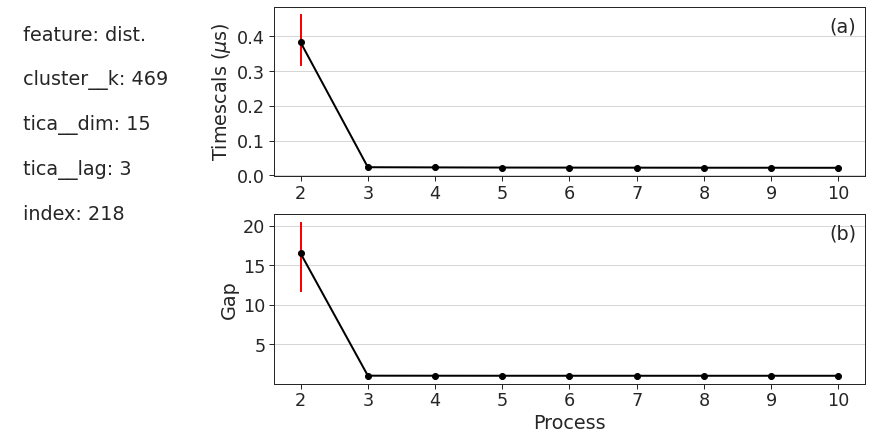

In [12]:
# Figure 2 : HP table + TS + TS gap

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=6, ncols=12)
    
    # Hyperparameter values
    ax1 = fig.add_subplot(gs[:, :3])
    ax1.text(0.05, 0.95, str_to_print, transform=ax1.transAxes, verticalalignment='top')
    
    ax1.axis('off')

    
    # Timescales
    ax2 = fig.add_subplot(gs[:3, 3:])
    x = np.arange(n_ts-1)+2
    y = ts_median
    yerr = (ts_median-ts_lb, ts_ub-ts_median)
    ax2.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax2.set_ylabel(r"Timescals ($\mu$s)")
    ax2.tick_params(bottom=True, top=False, left=True, right=False)
    ax2.annotate(text='(a)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax2.grid(visible=True, axis='y')

    
    # Gaps
    ax3 = fig.add_subplot(gs[3:, 3:])
    y = gap_median
    yerr = (gap_median-gap_lb, gap_ub-gap_median)
    ax3.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax3.set_ylabel("Gap")
    ax3.set_xlabel('Process')
    ax3.tick_params(bottom=True, top=False, left=True, right=False)
    ax3.annotate(text='(b)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax3.grid(visible=True, axis='y')

    plt.savefig(fig_dir.joinpath('SI_fig2.png'), bbox_inches='tight')

---
### Validate single MSM --- Figure 1

In [15]:
# Validate a single trial

ftrajs = ftrajs_all
assert len(ftrajs) == len(ftrajs_all)

ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)

out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
out_dir.mkdir(parents=True, exist_ok=True)

for j in range(len(traj_paths)): 
    traj_path = Path(traj_paths[j]).resolve()
    np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
_ = msm.pcca(n_sets)
ts = msm.timescales(n_ts)

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1370.71it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers:  99%|▉| 465/469 [00:06<00
kmeans iterations:   0%| | 1/1000 [00:06<1:53:03,  6.7
kmeans iterations:   0%| | 2/1000 [00:07<52:40,  3.17s
kmeans iterations:   0%| | 3/1000 [00:08<33:17,  2.00s

In [16]:
# Compute PCCA population
# Population may need to be reweighted ?

print('\nstate\tπ\t\tG/kT\t\tNo.')
population = []
number = []
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    population.append(p)
    number.append(s.shape[0])
    print('{}\t{:f}\t{:f}\t{}'.format(i, p, -np.log(p), s.shape[0]))


state	π		G/kT		No.
0	0.219532	1.516256	381
1	0.780468	0.247862	88


In [17]:
# Compute core set 

ix_ls = []
core_memberships = msm.metastable_memberships.T > core_membership_cutoff
for i in range(len(core_memberships)):
    ix_ls.append(np.where(core_memberships[i])[0])
core_sets = np.array(ix_ls)

# Compute MFPT between core sets

mfpt = np.zeros((n_sets, n_sets))
for i, j in product(range(n_sets), repeat=2):
    mfpt[i, j] = msm.mfpt(core_sets[i], core_sets[j])

mfpt_df = pd.DataFrame(np.round(mfpt, decimals=2), index=range(1, n_sets + 1), columns=range(1, n_sets + 1))
print(mfpt_df, '\n(ns)')

         1       2
1     0.00  515.62
2  1894.35    0.00 
(ns)


/tmp/ipykernel_2461413/564053929.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  core_sets = np.array(ix_ls)


In [20]:
# Map reference conformation

test_traj_path = [r'../../../chignolin/5AWL_H.pdb']
test_labels = '5AWL'

ftraj_test = featurizer(hps.loc[hp_ix, :].to_dict(), test_traj_path, top_path)
ftraj_test_tica = tica_mod.transform(ftraj_test)
microstate = kmeans_mod.assign(ftraj_test_tica)
metastate = msm.metastable_assignments[microstate]
#test_dict = {label:[test_traj_path[i], microstate[i][0], metastate[i][0]] for i, label in enumerate(test_labels)}

In [ ]:
mem = msm.metastable_memberships.transpose()

# Microstate positions
x = kmeans_mod.clustercenters[:, 0]
y = kmeans_mod.clustercenters[:, 1]  

# Concatenate featurised trajectories
Y = np.concatenate(ttrajs)

# Find cluster center
dists = msm.metastable_distributions.copy()
dists[msm.metastable_memberships.T<core_membership_cutoff] = 0
dists = dists/np.sum(dists, axis=1)[:, np.newaxis]
max_dists = dists.copy()
mask = max_dists==np.tile(np.max(max_dists, axis=1)[:, np.newaxis], (max_dists.shape[1]))
max_ix = np.where(mask)[1]

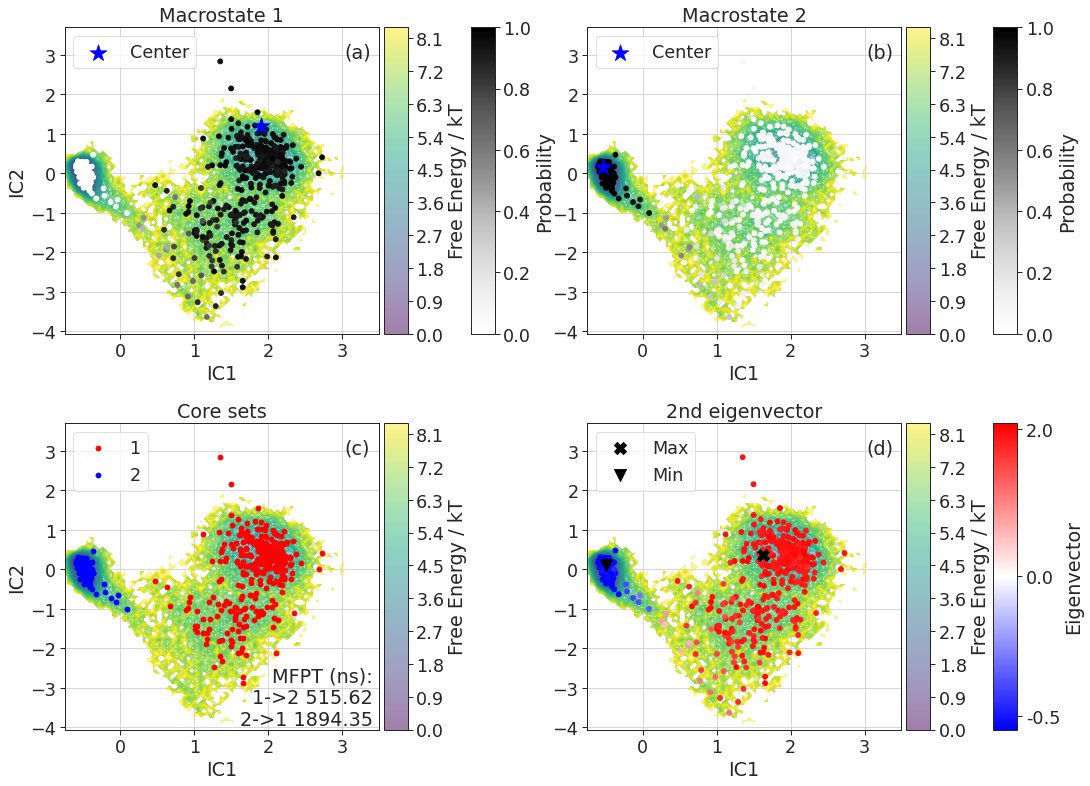

In [147]:
# Figure 1
pccas = []
pcca_cbs = []
fes_cbs = []

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(28, 28))
    gs = fig.add_gridspec(nrows=54, ncols=54)
    
    # Axes assignment 
    pccas.extend([fig.add_subplot(gs[:11, :11]), fig.add_subplot(gs[:11, 18:29])])
    mfpt = fig.add_subplot(gs[14:25, :11])   
    ev = fig.add_subplot(gs[14:25, 18:29])
    
    fes_cbs.extend([fig.add_subplot(gs[:11, 11]), fig.add_subplot(gs[:11, 29]),
                    fig.add_subplot(gs[14:25, 11]), fig.add_subplot(gs[14:25, 29])])
    pcca_cbs.extend([fig.add_subplot(gs[:11, 14]), fig.add_subplot(gs[:11, 32])])
    ev_cb = fig.add_subplot(gs[14:25, 32])
    
    if n_sets == 3: 
        pccas.append(fig.add_subplot(gs[:11, 36:47]))
        pcca_cbs.append(fig.add_subplot(gs[:11, 47]))
        fes_cbs.insert(2, fig.add_subplot(gs[:11, 50]))
    
        
    # Plot metastable membership
    for i_set, ax in enumerate(pccas):
        _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                    alpha=0.5, 
                                    weights=np.concatenate(msm.trajectory_weights()),
                                    cbar_label='Free Energy / kT', 
                                    ax=ax, cax=fes_cbs[i_set])
        
        # Microstates
        ms = pccas[i_set].scatter(x=x, y=y, c=mem[i_set], cmap='Greys', s=25, 
                       vmin=mem[i_set].min(), vmax=mem[i_set].max())
        cbar = plt.colorbar(ms, cax=pcca_cbs[i_set])
        cbar.ax.set_ylabel('Probability')
        
        # Macrostate centers 
        pccas[i_set].scatter(x=x[max_ix[i_set]],y=y[max_ix[i_set]], color='b', marker='*',
                             s=300, label='Center')
        
  
    # Plot core set assignment & MFPT
    _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                alpha=0.5, 
                                weights=np.concatenate(msm.trajectory_weights()),
                                cbar_label='Free Energy / kT', 
                                ax=mfpt, cax=fes_cbs[i_set+1])
    txt = 'MFPT (ns):\n'
    for i_set in range(n_sets):
        ms = mfpt.scatter(x=x[core_sets[i_set]], y=y[core_sets[i_set]], c=['r','b','m'][i_set],
                          label=f'{i_set+1}', s=25)
    if n_sets == 2:
        txt += f'1->2 {mfpt_df.iloc[0,1]}\n2->1 {mfpt_df.iloc[1,0]}'
    else:
        txt += f'1->2 {mfpt_df.iloc[0,1]}; 1>3{mfpt_df.iloc[0,2]}\n2->1 {mfpt_df.iloc[1,0]};2->3 {mfpt_df.iloc[1,2]}\n3->1 {mfpt_df.iloc[2,0]};3->2 {mfpt_df.iloc[2,1]} '
    
    
    # Plot 2nd eigenvector 
    _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                alpha=0.5, 
                                weights=np.concatenate(msm.trajectory_weights()),
                                cbar_label='Free Energy / kT', 
                                ax=ev, cax=fes_cbs[i_set+2])
    
    vmin = np.min(msm.eigenvectors_right()[:, 1]) 
    vmax = np.max(msm.eigenvectors_right()[:, 1]) 
    divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
    egv_max = msm.eigenvectors_right()[:, 1].argmax()
    egv_min = msm.eigenvectors_right()[:, 1].argmin()
    
    ms = ev.scatter(x=x, y=y, c=msm.eigenvectors_right()[:, 1], cmap='bwr', norm=divnorm, s=25)    
    ev.scatter(x=x[egv_max], y=y[egv_max], c='k', 
                  cmap='bwr', norm=divnorm, marker='X', s=150, alpha=1, label='Max')
    ev.scatter(x=x[egv_min], y=y[egv_min], c='k', 
                  cmap='bwr', norm=divnorm, marker='v', s=150, alpha=1, label='Min')
    cbar = plt.colorbar(ms, cax=ev_cb, ticks=[np.ceil(vmin*10)/10, 0, np.floor(vmax*10)/10])
    cbar.ax.set_yticklabels([np.ceil(vmin*10)/10, 0.0, np.floor(vmax*10)/10])
    cbar.ax.set_ylabel('Eigenvector')
    
    # Configurations
    for i_set, ax in enumerate(pccas):
        ax.tick_params(bottom=True, top=False, left=True, right=False)
        ax.grid(visible=True, axis='both')
        ax.legend(loc='upper left')
        ax.set_xlabel('IC1')
        ax.set_title(f'Macrostate {i_set+1}')
    pccas[0].set_ylabel('IC2')
    for ax in fes_cbs:
        ax.tick_params(bottom=False, top=False, left=False, right=True)
    for ax in pcca_cbs:
        ax.tick_params(bottom=False, top=False, left=False, right=True)
        
    mfpt.set_xlabel('IC1')
    mfpt.set_ylabel('IC2')
    mfpt.legend(loc='upper left')
    mfpt.annotate(text=txt, xy=(0.98, 0), xycoords='axes fraction', ha='right', va='bottom')
    mfpt.grid(visible=True, axis='both')
    mfpt.tick_params(bottom=True, top=False, left=True, right=False)
    mfpt.set_title('Core sets')
    
    ev.legend(loc='upper left')
    ev.grid(visible=True, axis='both')
    ev.set_xlabel('IC1')
    ev.tick_params(bottom=True, top=False, left=True, right=False)
    ev.set_title('2nd eigenvector')
    
    for i, ax in enumerate(pccas+[mfpt, ev]):
        ax.annotate(text=f'({string.ascii_lowercase[i]})', xy=(0.89, 0.95), xycoords='axes fraction', ha='left', va='top')
        
    
    plt.savefig(fig_dir.joinpath('SI_fig1.png'), bbox_inches='tight')
    plt.show()